# Import Statements

In [1]:
# general useful packages
import time, os, math, random
import pandas as pd # data analysis
import numpy as np # numerical analysis
import geopandas as gpd # spatial analysis

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

# modeling packages (stats and machine learning)
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.model_selection import train_test_split #for splitting into training/testing data

import warnings
warnings.filterwarnings('ignore')

In [2]:
#set color palette
cpal = sns.color_palette('Paired',12)

# Functions

In [3]:
def calc_NSE(obs,sim):
    """ Returns Nash-Sutcliffe Efficiency
    Input:
    obs - array of observed streamflow record
    sim - array of simulated streamflow record """
    return 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))

In [4]:
def future_stoch_mvnorm(df,df_fut,m):
    """Function that generates stochastic realizations for historical and future periods for all basins.
    Inputs:
    df: Pandas dataframe of annual runoff data in historical period.
    df_fut: Pandas dataframe of annual runoff data for future period.
    m: number of stochastic realizations.
    """
    
    basin_nms = df['basin_name'].unique() #get list of basin names
    nyears = len(df['year'].unique()) # time periods (every year)
    nbasins = len(basin_nms) # how many basins?
    nfyears = len(df_fut.year.unique()) # how many future time periods?

    # create numpy arrays for observed, deterministic model,and future deterministic projection (across all basins)
    q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
    q_obs = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
    qfut_sim = np.reshape(df_fut.groupby(['basin_id'],group_keys=False)['q_fut'].apply(lambda x:x).to_numpy(),
                       (nfyears,nbasins),order='F')

    # initialize empty storage arrays: 
    D_syn = np.zeros([nyears+nfyears,nbasins,m]) # store simulated differences
    Q_syn = np.zeros([nyears+nfyears,nbasins,m]) # store simulated runoff
    yfit_stor = np.zeros([nyears+nfyears,nbasins]) # store fitted means
    e_stor = np.zeros([nyears,nbasins]) # store errors
    sdp_stor = np.zeros([nyears+nfyears,nbasins]) # store standard deviation of prediction
    
    for j in range(nbasins): # loop through all of the basins
        boi = df[df.basin_name==basin_nms[j]] # boi = basin of interest
        boi_fut = df_fut[df_fut.basin_name==basin_nms[j]] # boi_fut = basin of interest future data
        q_obs_basin = boi.q_obs.to_numpy() # get historical reference annual runoff
        q_det_basin = boi.q_det.to_numpy()  # get historical deterministic model annual runoff
        qfut_sim_basin = boi_fut.q_fut.to_numpy() # get future projection annual runoff
        diff_basin = q_obs_basin - q_det_basin # difference between reference and deterministic model (historical)

        # fit OLS model
        X_basin = sm.add_constant(q_det_basin) #add column of ones to array of independent variable

        # calculate the mean
        beta = np.matmul(np.linalg.inv(np.matmul(X_basin.T,X_basin)),np.matmul(X_basin.T,diff_basin)) #these are the beta coefficients for OLS Y = Xb
        yfit = np.matmul(X_basin,beta) # model mean vector X*beta = yfit
        e = yfit - diff_basin # model residuals (difference between model fit and observed differences)
        sige = np.std(e) # standard deviation of model residuals

        # calculate variance of prediction
        vare = sige**2
        varyhat = vare * np.matmul(np.matmul(X_basin,np.linalg.inv(np.matmul(X_basin.T,X_basin))),X_basin.T)
        varypred = np.diag(varyhat+vare) #take diagonal elements of matrix
        
        # calculate future using model parameters from historical
        Xfut_basin = sm.add_constant(qfut_sim_basin) # add column of ones to future data
        yfit_fut = np.matmul(Xfut_basin,beta)   # Xfut*beta coefficients --> yfit future

        # #calculate variance of prediction for future
        varyhat_fut = vare*np.diag(np.matmul(np.matmul(Xfut_basin,np.linalg.inv(np.matmul(X_basin.T,X_basin))),Xfut_basin.T))
        varypred_fut = varyhat_fut+vare #take diagonal elements of matrix
        varypred_fut = np.array(varypred_fut,dtype='float')
        
        # save the values for yfit, model residuals e, and standard deviations of model residuals
        yfit_stor[:,j] = np.concatenate((yfit,yfit_fut))
        e_stor[:,j] = e
        sdp_stor[:,j] = np.concatenate((np.sqrt(varypred),np.sqrt(varypred_fut)))
    
    corr_e = np.corrcoef(e_stor.T) # calculate correlation structure across basins based on historical errors
    
    for i in range(nyears+nfyears): # now loop through time
        yfit_vals = yfit_stor[i,:]  # get mean vector for year i
        
        #build the covariance matrix for year i
        sd_vals = sdp_stor[i,:]
        sd_matrix = np.multiply.outer(sd_vals,sd_vals)
        cov_matrix = np.multiply(corr_e,sd_matrix)
            
        # generate errors from multivariate normal distribution (e*)
        D_syn[i,:,:] = np.random.multivariate_normal(yfit_vals,
                                                     cov_matrix,
                                                     m).T
        # calculate stochastic ensemble of runoff
        qdet_fut = np.concatenate((q_det,qfut_sim)) #add future deterministic to historical deterministic
        Q_syn[i,:,:] = np.tile(qdet_fut[i,:],(m,1)).T+D_syn[i,:,:] # qobs* = qdet + e*
        
    return Q_syn #return stochastic runoff ensemble


# Load in and clean up historical data

In [5]:
# set path to data
fpath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/gswp3w5e5data_19012019/'
histpath = 'isimip3a_watergap2-2e_gswp3-w5e5_runoff/'

# load in "observed" data - watergap2 model that xanthos is calibrated to
# watergap2 columns are basin, year, month, and runoff value.
obs_data = pd.read_csv(fpath+histpath+'watergap2-2e_gswp3-w5e5_obsclim_histsoc_nowatermgt_qtot_basin_km3-per-mth_1901_2019.csv')

# load in xanthos historical data used for calibration
# xanthos columns are yearmonth, rows are basins - from 1901 to 2010
det_data = pd.read_csv(fpath+histpath+'Basin_runoff_km3permonth_pm_abcd_mrtm_watergap2-2e_gswp3-w5e5_1901_2019.csv')

# load in map of global GCAM basins
gcam_basins = gpd.read_file(fpath+'gcam_basins/gcam_basins.shp')
gcam_basins = gcam_basins.filter(['sbRgnAl','geometry','area','subRegn'])
gcam_basins = gcam_basins.rename(columns={'sbRgnAl':'basin_id'})
gcam_basins['basin_id'] = gcam_basins['basin_id'].astype(int)

# create dictionary mapping basin name to basin id
basin_dict = dict(zip(det_data.name,det_data.id))

# convert deterministic model data to same format as observed data
det_data2 = det_data.T # transpose data frame
det_data2.columns = det_data2.iloc[1] # set column names to basin names
det_data2 = det_data2.iloc[2:] # remove first two rows of dataframe (column names and associated ID, will add back later)

det_data3 = det_data2.unstack() # reformat so year,month and basin_name are columns
det_data3 = det_data3.reset_index()
det_data3 = det_data3.rename(columns={'name':'basin_name','level_1':'year_month',0:'q'}) # rename columns
det_data3['basin_id'] = det_data3['basin_name'].map(basin_dict) # create column for basin ID
det_data3['year'] = det_data3['year_month'].str[0:4].astype(int) # create column for year
det_data3['month'] = det_data3['year_month'].str[4:].astype(int) # create column for month

# merge deterministic model and observed dataframes
obs_data = obs_data.rename(columns={'basin':'basin_id'}) # rename column for basin id in observed dataframe
data = obs_data.merge(det_data3,on=['basin_id','year','month'],suffixes=['_obs','_det']) # merge dataframes
data = data.filter(['basin_name','basin_id','year','month','q_obs','q_det'])

# Convert Runoff from Monthly to Annual
data['q_det'] = data['q_det'].astype(float)
data_annual = data.groupby(['basin_id','basin_name','year'])['q_obs','q_det'].sum() #annual runoff by basin
data_annual = data_annual.reset_index()

# load in recalibrated Upper Colorado Basin
up_col = np.load('/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/gswp3w5e5data_19012019/gutacalib_220.npy')
yrs = np.linspace(1901,2019,119).astype(int)
up_col_runoff = pd.DataFrame()
up_col_runoff['value'] = up_col
up_col_runoff['year'] = np.repeat(yrs,12)
up_col_runoff = up_col_runoff.groupby(['year'])['value'].sum().reset_index()

#replace the upper colorado with the recalibrated data
data_annual.loc[data_annual.basin_id==220,'q_det'] = up_col_runoff.value.to_numpy()

# Load in and clean up deterministic projection of future runoff

In [6]:
# path to data (GFDL SSP3 RCP7.0)
futpath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/gswp3w5e5data_19012019/isimip3b_cmip6_xanthos/'
scen = 'cmip6_gfdl-esm4_r1i1p1f1_ssp370/'

#read in data
fut_data = pd.read_csv(futpath+scen+'Basin_runoff_km3permonth_gfdl-esm4_r1i1p1f1_ssp370_1850_2100.csv')

#create dictionary mapping basin name to basin id
basin_dict = dict(zip(fut_data.name,fut_data.id))

#convert futulated data to same format as observed data
fut_data2 = fut_data.T #transpose data frame
fut_data2.columns = fut_data2.iloc[1] #set column names to basin names
fut_data2 = fut_data2.iloc[2:] #remove first two rows of dataframe (column names and associated ID, will add back later)

fut_data3 = fut_data2.unstack() #reformat so year,month and basin_name are columns
fut_data3 = fut_data3.reset_index()
fut_data3 = fut_data3.rename(columns={'name':'basin_name','level_1':'year_month',0:'q_fut'}) # rename columns
fut_data3['basin_id'] = fut_data3['basin_name'].map(basin_dict) # create column for basin ID
fut_data3['year'] = fut_data3['year_month'].str[0:4].astype(int) # create column for year
fut_data3['month'] = fut_data3['year_month'].str[4:].astype(int) # create column for month

fut_annual = fut_data3.groupby(['basin_id','basin_name','year'])['q_fut'].sum().reset_index() # annual runoff by basin
fut_annual = fut_annual[fut_annual.year>2019] # limit future to starting in 2020

# make sure data_annual and fut_annual are in proper order
data_annual = data_annual.sort_values(by=['basin_id','year'])
fut_annual = fut_annual.sort_values(by=['basin_id','year'])

# rename Missouri for both historical and future dataframes
data_annual.loc[data_annual.basin_name=='Missouri River Basin','basin_name'] = 'Missouri'
fut_annual.loc[fut_annual.basin_name=='Missouri River Basin','basin_name'] = 'Missouri'

#save data_annual and fut_annual
data_annual.set_index('basin_id').to_csv('/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/ensemble_1/hist_annual.csv',encoding='utf-8',header=True)
fut_annual.set_index('basin_id').to_csv('/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/ensemble_1/fut_annual_gfdl_ssp370.csv',encoding='utf-8',header=True)

# Run Stochastic Model for 1000 simulations

In [7]:
df = data_annual # historical data
df_fut = fut_annual # future data
m = 1000 # number of stochastic realizations to generate

Q = future_stoch_mvnorm(df,df_fut,m) #simulate stochastic realizations

# make sure there are no negative runoff values - set minimum to be zero for both historical and future
Q[Q<0] = 0

basin_nms = data_annual.basin_name.unique() # get basin names
nbasins = len(basin_nms) # get # of basins
nyears = len(data_annual['year'].unique()[:]) # get # of years

# get historical values
Q_hist = Q[:nyears,:,:]
q_ref = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')

# get future values
Q_fut = Q[nyears:,:,:]
nfyears = len(fut_annual.year.unique())
fut_annual['q_fut'] = fut_annual['q_fut'].astype(float)
q_fut = np.reshape(fut_annual.groupby(['basin_id'],group_keys=False)['q_fut'].apply(lambda x:x).to_numpy(),
                       (nfyears,nbasins),order='F')


# Figure SX: How does model do with 70/30 training/testing data split?

In [8]:
def model_test(df,rs,m):
    """This function is used to test performance of SWM developed in this work using a 70/30 split of 
    training/testing data.
    
    Inputs:
    df: dataframe
    rs: random seed
    m: # stochastic realizations to generate
    
    Outputs:
    BLAH
    """
    
    basin_nms = df['basin_name'].unique() #get names of basins
    nyears = len(df['year'].unique()) #get number of years
    nbasins = len(basin_nms) #get number of basins

    #create numpy arrays for observed and deterministic model of historical annual runoff
    q_obs = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
    q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
    q_diff = q_obs - q_det #difference between obs and det (what we're modeling)

    indices = np.arange(nyears) #get numpy array of indices
    
    #split the data into training and test
    X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(q_det, q_diff, indices,test_size=0.3, random_state=rs)
    ntrain = len(X_train) #length of training dataset
    
    #create empty storage arrays
    D_syn = np.zeros([nyears,nbasins,m])
    Q_syn = np.zeros([nyears,nbasins,m])
    yfit_stor = np.zeros([nyears,nbasins])
    e_stor = np.zeros([ntrain,nbasins])
    sdp_stor = np.zeros([nyears,nbasins])
    
    #create ind_list variable that indicates the indices of the training and testing data (so we can put back in order)
    ind_list = np.concatenate((ind_train,ind_test))
    #create ind_reorder array that will be used to reorder back to original time series
    ind_reorder = np.zeros(nyears)
    for i in range(nyears):
        ind_reorder[i] = np.where(ind_list==i)[0]
    ind_reorder = ind_reorder.astype(int)
    
    for j in range(nbasins):#loop through all of the basins
        q_basin_train = X_train[:,j] #select basin j training data
        q_basin_test = X_test[:,j] #select basin j testing data
        diff_basin_train = y_train[:,j] #select basin j differences for training data
        diff_basin_test = y_test[:,j] #select basin j differences for testing data
        
        X_basin_train = sm.add_constant(q_basin_train) #add column of ones to array of independent variable

        #calculate mean and variance of prediction
        beta = np.matmul(np.linalg.inv(np.matmul(X_basin_train.T,X_basin_train)),
                         np.matmul(X_basin_train.T,diff_basin_train)) #these are the beta coefficients for OLS Y = Xb
        yfit_train = np.matmul(X_basin_train,beta)
        e = yfit_train - diff_basin_train
        sige = np.std(e) #standard deviation of fitted model minus D
        vare = sige**2
        varyhat_train = vare * np.matmul(np.matmul(X_basin_train,
                                                   np.linalg.inv(np.matmul(X_basin_train.T,X_basin_train))),X_basin_train.T)
        varypred_train = np.diag(varyhat_train+vare) #take diagonal elements of matrix

        #Now apply model fit to training data onto the testing data!
        X_basin_test = sm.add_constant(q_basin_test)
        yfit_test = np.matmul(X_basin_test,beta)   #Xfut*beta coefficients --> yfit future
        varyhat_test = vare*np.diag(np.matmul(np.matmul(X_basin_test,
                                                        np.linalg.inv(np.matmul(X_basin_train.T,X_basin_train))),X_basin_test.T))
        varypred_test = varyhat_test+vare #take diagonal elements of matrix
        varypred_test = np.array(varypred_test,dtype='float')

        # save the values for yfit, model residuals e, and standard deviations of model residuals
        yfit_stor[:,j] = np.concatenate((yfit_train,yfit_test))
        e_stor[:,j] = e
        sdp_stor[:,j] = np.concatenate((np.sqrt(varypred_train),np.sqrt(varypred_test)))
        
    #create matrix of correlation in the errors
    corr_e = np.corrcoef(e_stor.T) #size of e is # training years x #basins
    
    #reorder q_det to match ind_list order
    q_det_reorder = q_det[ind_list]
    
    #loop through years to sample stochastically from errors
    for i in range(nyears):
        yfit_vals = yfit_stor[i,:] #get mean vector for year i
        #build the covariance matrix for year i
        sd_vals = sdp_stor[i,:]
        sd_matrix = np.multiply.outer(sd_vals,sd_vals)
        corr_e = np.corrcoef(e_stor.T)
        cov_matrix = np.multiply(corr_e,sd_matrix)

        #generate errors from multivariate normal distribution
        D_syn[i,:,:] = np.random.multivariate_normal(yfit_vals,cov_matrix,m).T
        Q_syn[i,:,:] = np.tile(q_det_reorder[i,:],(m,1)).T+D_syn[i,:,:]#qobs* = qsyn = qdet + D*
    
    #reorder Q_syn to the correct order based on ind_reorder
    Q_reorder = Q_syn[ind_reorder]
        
    return Q_reorder,ind_list,ntrain

In [9]:
#run 70/30 split model for w random seeds
nrs = 5 # number of random seeds
df = data_annual.copy()
nbasins = len(df.basin_id.unique())
nyears = len(df.year.unique())
m = 1000
#rs_range = np.linspace(1,100,100).astype(int)
rs_range = np.linspace(1,nrs,nrs).astype(int)
ind_stor = np.zeros([nyears,len(rs_range)])
Q_seeds = np.zeros([nyears,nbasins,m,len(rs_range)])

for i in range(len(rs_range)):
    Q_seeds[:,:,:,i],ind_stor[:,i],ntrain = model_test(df,rs_range[i],m)
    #shape of Q_seeds is #years x #basins x #realizations x #seeds

In [10]:
# plot mean qobs versus qmodel
q_obs = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')

In [11]:
stor_mod_means = np.zeros([nrs,nbasins])
stor_mod_vars = np.zeros([nrs,nbasins])

#calculate mean/var for observed for each basin
obs_mean = np.mean(q_obs,axis=0)
obs_var = np.var(q_obs,axis=0)

for w in range(nrs): #loop through random seeds
    q_obs_reorder = q_obs[:,:][ind_stor[:,w].astype(int)] #reorder observed data indices to match that of training/test data for given seed
    q_model_reorder = Q_seeds[:,:,:,w][ind_stor[:,w].astype(int)] #reordered to training/test data, size is 119x235xm
    
    #calculate mean and variance across years for each basin
    stor_mod_means[w,:] = np.mean(np.mean(q_model_reorder,axis=0),axis=1) #mean over time then mean over stoch. realizations
    stor_mod_vars[w,:]= np.mean(np.var(q_model_reorder,axis=0),axis=1) #var over time then mean over stoch. realizations

Text(0.5, 1.0, 'Mean Annual Runoff - Training + Test Years')

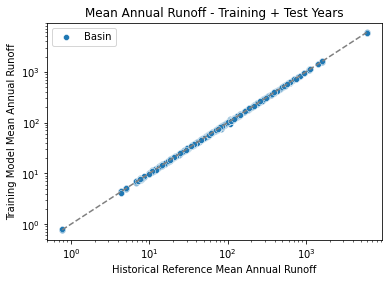

In [12]:
sns.scatterplot(x=obs_mean,y=stor_mod_means[0,:],color=cpal[1])
sns.scatterplot(x=obs_mean,y=stor_mod_means[1,:],color=cpal[1])
sns.scatterplot(x=obs_mean,y=stor_mod_means[2,:],color=cpal[1])
sns.scatterplot(x=obs_mean,y=stor_mod_means[3,:],color=cpal[1])
sns.scatterplot(x=obs_mean,y=stor_mod_means[4,:],color=cpal[1])
sns.lineplot(x=np.linspace(np.min(obs_mean),np.max(obs_mean),100),
             y=np.linspace(np.min(obs_mean),np.max(obs_mean),100),ls='--',color='gray')
plt.legend(['Basin'])
plt.xlabel('Historical Reference Mean Annual Runoff')
plt.ylabel('Training Model Mean Annual Runoff')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean Annual Runoff - Training + Test Years')

Text(0.5, 1.0, 'Variance Annual Runoff - Training + Test Years')

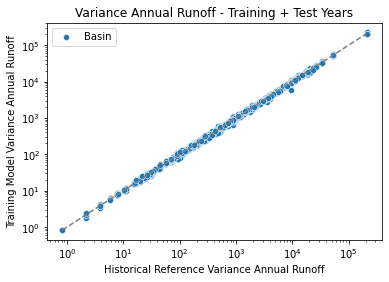

In [13]:
sns.scatterplot(x=obs_var,y=stor_mod_vars[0,:],color=cpal[1])
sns.scatterplot(x=obs_var,y=stor_mod_vars[1,:],color=cpal[1])
sns.scatterplot(x=obs_var,y=stor_mod_vars[2,:],color=cpal[1])
sns.scatterplot(x=obs_var,y=stor_mod_vars[3,:],color=cpal[1])
sns.scatterplot(x=obs_var,y=stor_mod_vars[4,:],color=cpal[1])
sns.lineplot(x=np.linspace(np.min(obs_var),np.max(obs_var),100),
             y=np.linspace(np.min(obs_var),np.max(obs_var),100),ls='--',color='gray')
plt.legend(['Basin'])
plt.xlabel('Historical Reference Variance Annual Runoff')
plt.ylabel('Training Model Variance Annual Runoff')
plt.xscale('log')
plt.yscale('log')
plt.title('Variance Annual Runoff - Training + Test Years')

In [14]:
#just on testing data
stor_mod_means = np.zeros([nrs,nbasins])
stor_mod_vars = np.zeros([nrs,nbasins])

for w in range(nrs): #loop through random seeds
    q_obs_reorder = q_obs[:,:][ind_stor[:,w].astype(int)] #reorder observed data indices to match that of training/test data for given seed
    q_model_reorder = Q_seeds[:,:,:,w][ind_stor[:,w].astype(int)] #reordered to training/test data, size is 119x235xm
    
    #calculate mean and variance across years for each basin
    stor_mod_means[w,:] = np.mean(np.mean(q_model_reorder[ntrain:,:,:],axis=0),axis=1) #mean over time then mean over stoch. realizations
    stor_mod_vars[w,:]= np.mean(np.var(q_model_reorder[ntrain:,:,:],axis=0),axis=1) #var over time then mean over stoch. realizations
    
#calculate mean/var for observed for each basin
obs_mean = np.mean(q_obs_reorder[ntrain:,:],axis=0)
obs_var = np.var(q_obs_reorder[ntrain:,:],axis=0)

In [15]:
#just on testing data
stor_mod_means = np.zeros([nrs,nbasins,m])
stor_mod_vars = np.zeros([nrs,nbasins,m])

for w in range(nrs): #loop through random seeds
    q_obs_reorder = q_obs[:,:][ind_stor[:,w].astype(int)] #reorder observed data indices to match that of training/test data for given seed
    q_model_reorder = Q_seeds[:,:,:,w][ind_stor[:,w].astype(int)] #reordered to training/test data, size is 119x235xm
    
    #calculate mean and variance across years for each basin
    stor_mod_means[w,:,:] = np.mean(q_model_reorder[ntrain:,:,:],axis=0) #mean over time then mean over stoch. realizations
    stor_mod_vars[w,:,:]= np.var(q_model_reorder[ntrain:,:,:],axis=0) #var over time then mean over stoch. realizations
    
#calculate mean/var for observed for each basin
obs_mean = np.mean(q_obs_reorder[ntrain:,:],axis=0)
obs_var = np.var(q_obs_reorder[ntrain:,:],axis=0)

Text(0.5, 1.0, 'Mean Annual Runoff - Test Years Only')

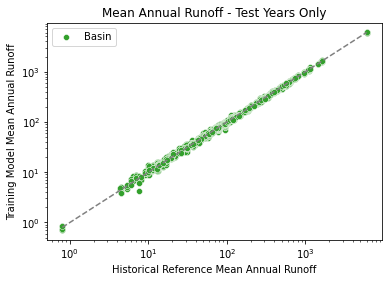

In [16]:
for i in range(1):##m):
    sns.scatterplot(x=obs_mean,y=stor_mod_means[0,:,i],color=cpal[3])
    sns.scatterplot(x=obs_mean,y=stor_mod_means[1,:,i],color=cpal[3])
    sns.scatterplot(x=obs_mean,y=stor_mod_means[2,:,i],color=cpal[3])
    sns.scatterplot(x=obs_mean,y=stor_mod_means[3,:,i],color=cpal[3])
    sns.scatterplot(x=obs_mean,y=stor_mod_means[4,:,i],color=cpal[3])
sns.lineplot(x=np.linspace(np.min(obs_mean),np.max(obs_mean),100),
             y=np.linspace(np.min(obs_mean),np.max(obs_mean),100),ls='--',color='gray')
plt.legend(['Basin'])
plt.xlabel('Historical Reference Mean Annual Runoff')
plt.ylabel('Training Model Mean Annual Runoff')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean Annual Runoff - Test Years Only')

Text(0.5, 1.0, 'Variance of Annual Runoff - Test Years Only')

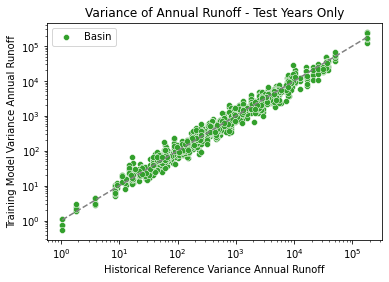

In [17]:
sns.scatterplot(x=obs_var,y=stor_mod_vars[0,:,0],color=cpal[3])
sns.scatterplot(x=obs_var,y=stor_mod_vars[1,:,0],color=cpal[3])
sns.scatterplot(x=obs_var,y=stor_mod_vars[2,:,0],color=cpal[3])
sns.scatterplot(x=obs_var,y=stor_mod_vars[3,:,0],color=cpal[3])
sns.scatterplot(x=obs_var,y=stor_mod_vars[4,:,0],color=cpal[3])
sns.lineplot(x=np.linspace(np.min(obs_var),np.max(obs_var),100),
             y=np.linspace(np.min(obs_var),np.max(obs_var),100),ls='--',color='gray')
plt.legend(['Basin'])
plt.xlabel('Historical Reference Variance Annual Runoff')
plt.ylabel('Training Model Variance Annual Runoff')
plt.xscale('log')
plt.yscale('log')
plt.title('Variance of Annual Runoff - Test Years Only')

In [18]:
#also calculate NSE (or log-NSE for each basin)?

# Figure SX: How does model do at preserving cross correlation structure of observed runoff?

In [19]:
# determine the cross-correlation between every two basins for the different flow datasets
basin_ids = data_annual.basin_id.unique()[:]
basin_names = data_annual.basin_name.unique()[:]
nyears = len(data_annual.year.unique())
nbasins = len(data_annual.basin_id.unique())

#for observed historical (watergap2)
q_obs = np.reshape(data_annual.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F') #matrix of runoff values
corr_vals_obs = np.corrcoef(q_obs.T) #cross correlation coefficients

#for simulated historical (xanthos)
q_det = np.reshape(data_annual.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F') #matrix of runoff values
corr_vals_det = np.corrcoef(q_det.T) #cross correlation coefficients

#correlation structure of the errors
q_diff = q_obs - q_det #matrix of differences in runoff
corr_vals_err = np.corrcoef(q_diff.T) #cross correlation coefficients of differences

In [20]:
def corr_vals_stoch(Q_syn,m,nbasins):
    """ Calculates the cross correlation coefficient across the basins for all stochastic realizations.
        Q: input numpy array containing runoff values
        m: # stochastic realizations
        nbasins: # basins."""
    corr_vals_stoch = np.zeros([nbasins,nbasins,m])
    for k in range(m):
        corr_vals_stoch[:,:,k] = np.corrcoef(Q_syn[:,:,k].T) #get the correlation coefficients for each stochastic realization
    return corr_vals_stoch

In [21]:
corr_vals_stoch = corr_vals_stoch(Q_hist,m,nbasins)

In [22]:
corr_vals_stoch_med = np.mean(corr_vals_stoch,axis=2)

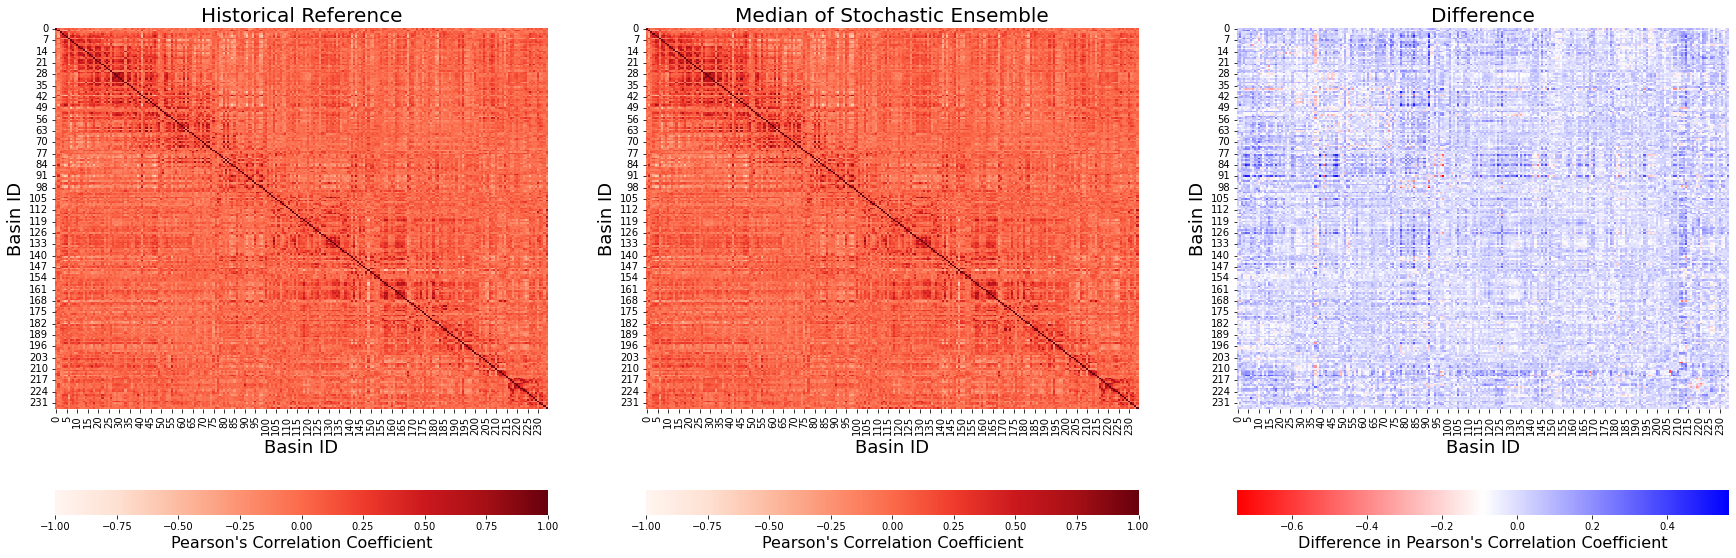

In [23]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,10))

#observed
sns.heatmap(data=corr_vals_obs,vmin=-1,vmax=1,cmap='Reds',ax=ax1,cbar_kws={'label':'Pearson\'s Correlation Coefficient',
                                                                          'orientation':'horizontal'})
ax1.set_xlabel('Basin ID',fontsize=18)
ax1.set_ylabel('Basin ID',fontsize=18)
ax1.set_title('Historical Reference',fontsize=20)
ax1.figure.axes[-1].xaxis.label.set_size(16)

#stochastic median
sns.heatmap(data=corr_vals_obs,cmap='Reds',vmin=-1,vmax=1,ax=ax2,cbar_kws={'label':'Pearson\'s Correlation Coefficient',
                                                                          'orientation':'horizontal'})
ax2.set_xlabel('Basin ID',fontsize=18)
ax2.set_ylabel('Basin ID',fontsize=18)
ax2.set_title('Median of Stochastic Ensemble',fontsize=20)
ax2.figure.axes[-1].xaxis.label.set_size(16)

#difference
corr_vals_diff = corr_vals_stoch_med-corr_vals_obs
sns.heatmap(data=corr_vals_diff,cmap='bwr_r',
            ax=ax3,cbar_kws={'label':'Difference in Pearson\'s Correlation Coefficient','orientation':'horizontal'})
ax3.set_xlabel('Basin ID',fontsize=18)
ax3.set_ylabel('Basin ID',fontsize=18)
ax3.set_title('Difference',fontsize=20)
ax3.figure.axes[-1].xaxis.label.set_size(16)

plt.show()


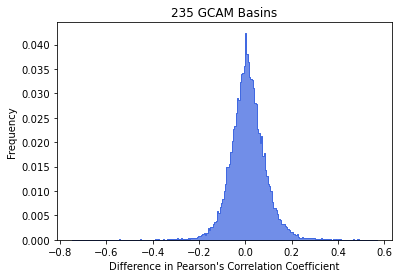

In [24]:
ntril = np.tril_indices(nbasins)
cvd = corr_vals_diff[ntril]
sns.histplot(cvd,stat='probability',color='royalblue',element='step')
plt.xlabel('Difference in Pearson\'s Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('235 GCAM Basins')
plt.show()

# Figure S3: breakdown of relative bias, variance, and correlation for selected basins

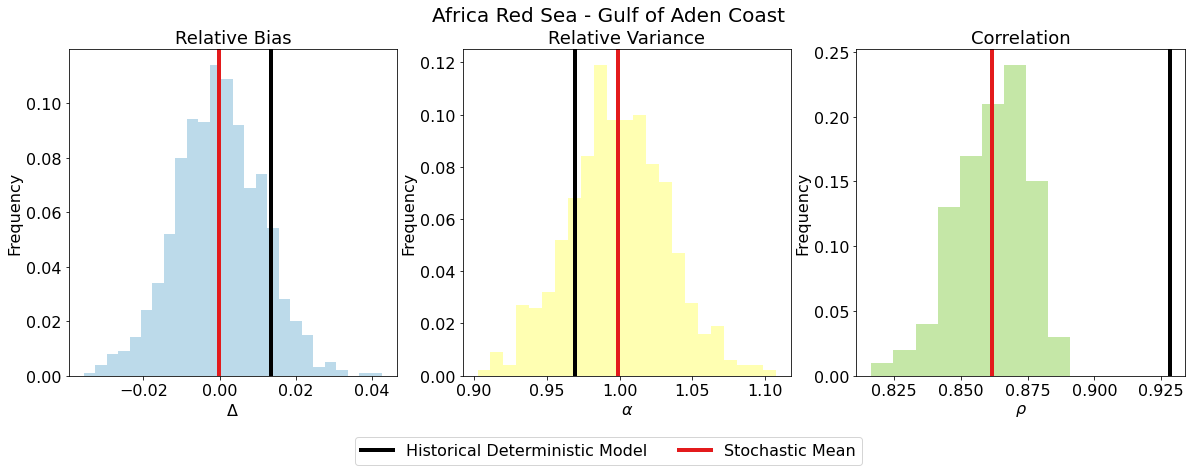

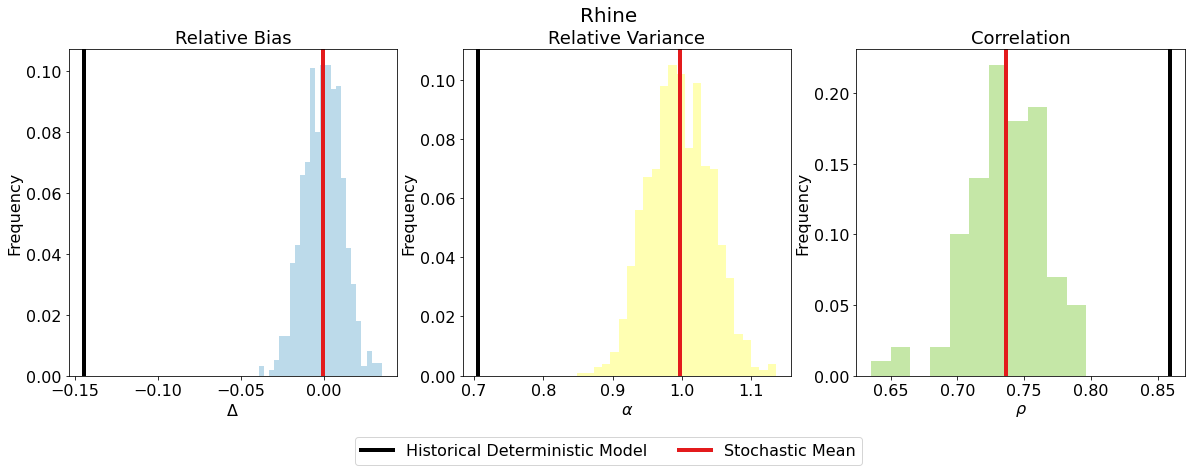

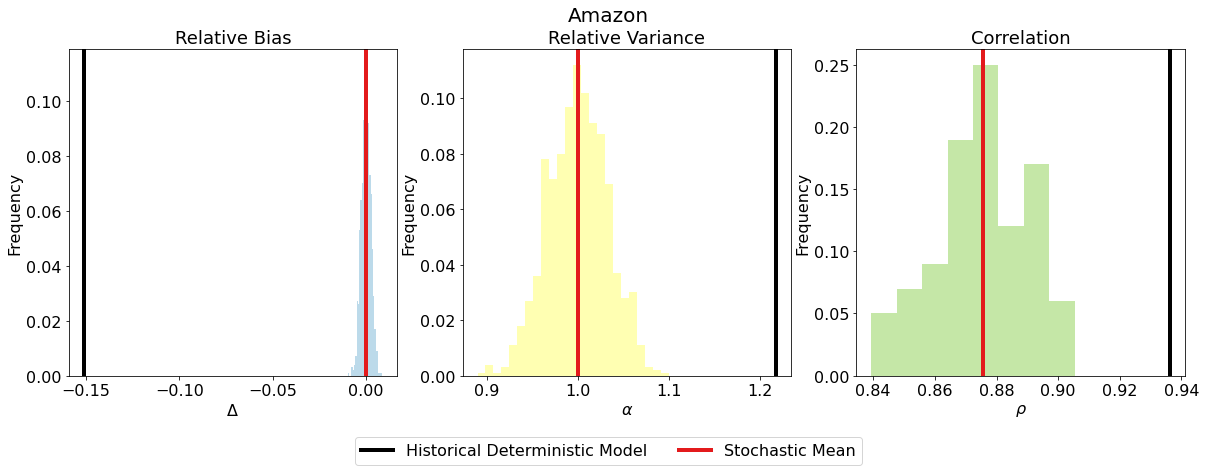

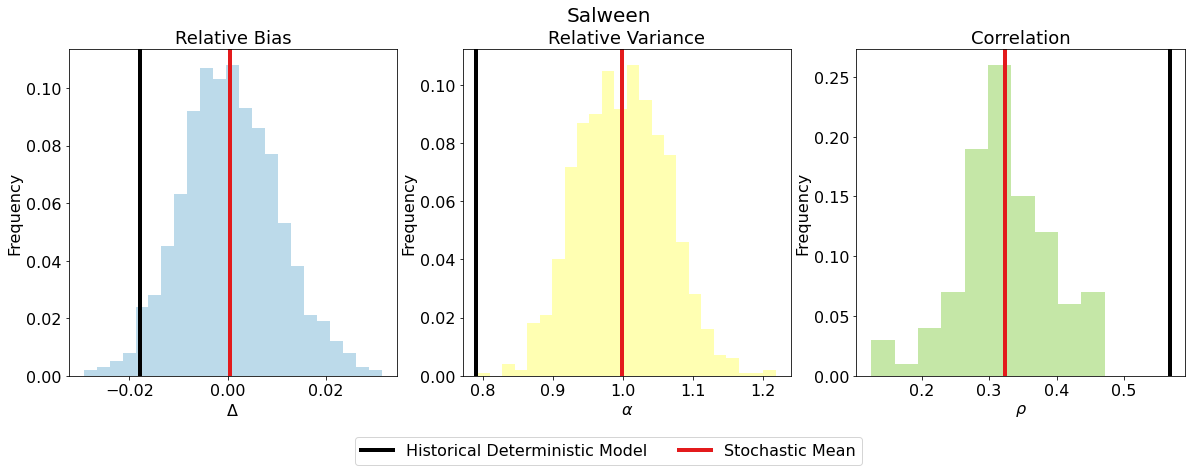

In [62]:
bsid_list = [100,32,168,127]
#100, 32, 168, 127
for bsid in bsid_list:
    df_basin = data_annual[data_annual.basin_id==bsid]
    bsnm = df_basin.basin_name.iloc[0]
    df_basin_stoch = Q_hist[:,bsid-1,:]

    #observed
    mu_obs = np.mean(df_basin.q_obs)
    sig_obs = np.std(df_basin.q_obs)

    #deterministic
    mu_det = np.mean(df_basin.q_det)
    sig_det = np.std(df_basin.q_det)
    rho_det = np.corrcoef(df_basin.q_obs,df_basin.q_det)[0,1]
    delta_det = (mu_obs - mu_det)/mu_obs
    alpha_det = sig_det/sig_obs

    #stochastic
    mu_stoch = np.mean(df_basin_stoch,axis=0)
    sig_stoch = np.std(df_basin_stoch,axis=0)
    rho_stoch = np.zeros(m)
    for i in range(m):
        rho_stoch[i] = np.corrcoef(df_basin.q_obs,df_basin_stoch[:,i])[0,1]
    delta_stoch= (mu_obs - mu_stoch)/mu_obs
    alpha_stoch = sig_stoch/sig_obs

    #make plots
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6))

    sns.histplot(x=delta_stoch,ax=ax1,stat='probability',color=cpal[0],edgecolor=None)
    ax1.set_xlabel(r'$\Delta$',fontsize=16)
    ax1.set_ylabel('Frequency',fontsize=16)
    ax1.axvline(delta_det,color='k',lw=4,label='Deterministic Model')
    ax1.axvline(np.mean(delta_stoch),color=cpal[5],lw=4,label='Stochastic Mean')
    ax1.yaxis.set_tick_params(labelsize=16)
    ax1.xaxis.set_tick_params(labelsize=16)
    ax1.set_title('Relative Bias',fontsize=18)

    sns.histplot(x=alpha_stoch,ax=ax2,stat='probability',color=cpal[10],edgecolor=None)
    ax2.set_xlabel(r'$\alpha$',fontsize=16)
    ax2.set_ylabel('Frequency',fontsize=16)
    ax2.axvline(alpha_det,color='k',lw=4,label='Deterministic Model')
    ax2.axvline(np.mean(alpha_stoch),color=cpal[5],lw=4,label='Stochastic Mean')
    ax2.yaxis.set_tick_params(labelsize=16)
    ax2.xaxis.set_tick_params(labelsize=16)
    ax2.set_title('Relative Variance',fontsize=18)

    sns.histplot(x=rho_stoch,ax=ax3,stat='probability',color=cpal[2],edgecolor=None)
    ax3.set_xlabel(r'$\rho$',fontsize=16)
    ax3.set_ylabel('Frequency',fontsize=16)
    ax3.axvline(rho_det,color='k',lw=4,label='Deterministic Model')
    ax3.axvline(np.mean(rho_stoch),lw=4,color=cpal[5],label='Stochastic Mean')
    ax3.set_title('Correlation',fontsize=18)
    ax3.yaxis.set_tick_params(labelsize=16)
    ax3.xaxis.set_tick_params(labelsize=16)
    fig.legend(['Historical Deterministic Model','Stochastic Mean'],ncol=2,loc='lower center',bbox_to_anchor=(0.5, -0.1),fontsize=16)
    plt.suptitle(bsnm,fontsize=20)
    plt.show()

In [ ]:
# fit ARIMA model to basins
def get_AIC(x,ar,di,ma):
    """fit ARIMA model to basin errors"""
    ar_return = 0
    ar_vals = [ar+1,ar+2]#,ar+2,ar+3] #lags to test (set up right now just to test ar = 0 and ar = 1)
    #calculate AIC for AR = 0
    mod = sm.tsa.statespace.SARIMAX(x, trend='c', order=(ar,di,ma),)
    res = mod.fit(disp=False)
    aic_min = res.aic
    for i in range(len(ar_vals)):
        mod = sm.tsa.statespace.SARIMAX(x, trend='c', order=(ar_vals[i],di,ma),)
        res = mod.fit(disp=False)
        if np.log2(res.aic/aic_min) < -1:
        #if res.aic < aic_min:
            aic_min = res.aic
            ar_return = ar_vals[i]
    return ar_return

from statsmodels.tsa.stattools import adfuller
def diff_needed(x):
    #ad fuller test
    dftest = adfuller(x, autolag='AIC')
    pval = dftest[1]
    adf_res = 0
    if pval>=0.05: #if p-value is less than 0.05 (5%), can reject h0 and assume stationary. If >= 0.05, assume non-stationary
        adf_res = 1
    return adf_res

In [ ]:
ar = 0
di = 0
ma = 0

aic = df_new.groupby(['basin_id'],group_keys=False)['resid'].apply(lambda x: get_AIC(x,ar,di,ma)).to_numpy()
adf = df_new.groupby(['basin_id'],group_keys=False)['resid'].apply(lambda x: diff_needed(x)).to_numpy()

arima_mod = pd.DataFrame({'basin_id':basin_list,'adf':adf,'aic':aic})

In [ ]:
arima_mod = gcam_basins.merge(arima_mod,on=['basin_id'])

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
arima_mod.plot(column = aic, categorical=True,ax=ax,cmap='Set3',legend=True,edgecolor='k',
              legend_kwds={'title':'AIC'})
ax.set_axis_off();

In [ ]:
arima_mod.aic.value_counts()

In [ ]:
arima_mod.adf.value_counts()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
arima_mod.plot(column = adf, categorical=True,ax=ax,cmap='Set3',legend=True,edgecolor='k',
              legend_kwds={'title':'ADF'})
ax.set_axis_off();